In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nelpy as nel
import glob
import os
import skvideo.io
import scipy as sp
from scipy.interpolate import interp1d
from caiman.source_extraction.cnmf.cnmf import load_CNMF
import caiman as cm
from caiman.base.rois import com
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import warnings
warnings.simplefilter("ignore")
%matplotlib inline

plt.rcParams['svg.fonttype'] = 'none'

/home/jchu/code/nelpy/nelpy/plotting/decoding.py:9: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
/home/jchu/applications/anaconda3/envs/caiman/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
/home/jchu/applications/anaconda3/envs/caiman/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
/home/jchu/applications/anaconda3/envs/caiman/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (ty

# Functions

In [25]:
def get_ratemaps(spikes_asa, pos2d_asa, run_epochs):
    """Compute ratemaps for all units
    
    Parameters
    ----------
    spikes_asa : nelpy.AnalogSignalArray
        Contains the spiking activity
    pos2d_asa : nelpy.AnalogSignalArray
        Positions in the open field
    run_epochs : nelpy.EpochArray
        Periods when animal is running
        
    Returns
    -------
    norm_ratemap : np.ndarray 
        Occupancy-normalized ratemap, of shape (n_units, 40, 60)
    occupany : np.ndarray
    """

    sub_spikes_asa = spikes_asa[run_epochs]
    sub_pos2d_asa = pos2d_asa[run_epochs]

    H, axis_0_edges, axi_1_edges = np.histogram2d(sub_pos2d_asa.data[0], sub_pos2d_asa.data[1], bins=[60, 40])
    occupancy = H.T / 30

    x_bins = (sub_pos2d_asa.data[0]).astype(int)
    y_bins = (sub_pos2d_asa.data[1]).astype(int)

    ratemap = np.zeros((spikes_asa.n_signals, 40, 60))
    spike_data = sub_spikes_asa[run_epochs].data
    assert len(x_bins) == spike_data.shape[1]

    for jj in range(len(x_bins)):
        for kk in range(spikes_asa.n_signals):
            axis_1_bin = x_bins[jj]
            axis_0_bin = y_bins[jj]
            if axis_1_bin == 60:
                axis_1_bin = 59
            if axis_0_bin == 40:
                axis_0_bin = 39
            # image/matrix coordinates
            ratemap[kk, axis_0_bin, axis_1_bin] += spike_data[kk, jj]

    norm_ratemap = ratemap / occupancy
    norm_ratemap[~np.isfinite(norm_ratemap)] = 0
    norm_ratemap += 1e-6
    
    return norm_ratemap, occupancy

In [26]:
def display_ratemap(spikes_asa, pos2d_asa, run_epochs, norm_ratemap, unit, ax):
    """Shows ratemap
    
    Parameters
    ----------
    spikes_asa : nelpy.AnalogSignalArray
        Contains the spiking activity
    pos2d_asa : nelpy.AnalogSignalArray
        Positions in the open field
    run_epochs : nelpy.EpochArray
        Periods when animal is running
    norm_ratemap : np.ndarray 
        Occupancy-normalized ratemap
    unit : integer
        Which signal index in the spikes_asa to plot
    ax : matplotlib.Axes
        Axes to plot to
        
    Returns
    -------
    The axes object originally passed in
    
    """

    # positions go in bottom layer
    ax.plot(pos2d_asa.data[0], 40 - pos2d_asa.data[1])

    # compute smoothed ratemaps
    smoothed_ratemap = sp.ndimage.gaussian_filter(norm_ratemap[unit], 2, truncate=2)
    smoothed_ratemap -= smoothed_ratemap.min()
    smoothed_ratemap /= smoothed_ratemap.max()

    # where the ratemap is 0, show as white
    ma = np.ma.masked_where(smoothed_ratemap == 0, smoothed_ratemap)
    cmap = mpl.cm.Greens
    cmap.set_bad('white')

    # next, overlay the ratemap
    im = ax.imshow(ma, extent=[0, 60, 0, 40], cmap=cmap, interpolation='bicubic')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    
    spikes = spikes_asa[run_epochs].data[unit]
    x_locs = (pos2d_asa[run_epochs].data[0])
    y_locs = (pos2d_asa[run_epochs].data[1])
    mask = spikes > 0

    # figure out where to plot spikes when they are nonzero
    mask = spikes > 0
    plot_x_loc = x_locs[mask]
    plot_y_loc = y_locs[mask]
    spike_arr = spikes[mask]

    # display size for spikes
    spike_arr /= spike_arr.max()
    spike_arr = 5/4*spike_arr + 5

    for jj in range(len(spike_arr)):
        ax.plot(plot_x_loc[jj], 40 - plot_y_loc[jj], 'o', color='#ff7f0e', markersize=spike_arr[jj])

    ax.set_title(f"Unit {unit+1}")
    ax.tick_params(axis='both', which='both', bottom=False, labelbottom=False, left=False, labelleft=False)
    
    return ax

# Load relevant data

In [2]:
with np.load('data/timestamps-and-coords.npz') as f:
    valid_ts = f['valid_ts']
    neural_ts = f['neural_ts']
    coords_cm = f['coords_cm']

max_proj = np.load('data/max_proj.npy')
place_cell_inds = np.load('data/place_cell_inds.npy')

# too large for GitHub, if needed, will have to share some other way
cnm_seeded = load_CNMF('data/cnm_seeded.hdf5')

# soft link to huge file needed for 2e. If people want to replicate that panel, will need to share
# data some other way
# Yr, dims, T = cm.load_memmap('data/all_d1_1040_d2_1320_d3_1_order_C_frames_30257_.mmap')
# images = Yr.T.reshape((T,) + dims, order='F')

# Construct objects and compute ratemaps

In [3]:
# interpolate missing values for position
f_x = interp1d(valid_ts, coords_cm[:, 0])
f_y = interp1d(valid_ts, coords_cm[:, 1])

# only look at spikes where we have position timestamps
t_start, t_end = np.searchsorted(neural_ts, [valid_ts[0], valid_ts[-1]])
neural_ts_new = neural_ts[t_start:t_end]

print(valid_ts.shape, neural_ts_new.shape)

(28354,) (30203,)


In [4]:
# construct asa and interpolate positions at desired time points
spikes_asa = nel.AnalogSignalArray(cnm_seeded.estimates.S[cnm_seeded.estimates.idx_components, t_start:t_end],
                            abscissa_vals=neural_ts_new,
                            support=nel.EpochArray([neural_ts_new[0], neural_ts_new[-1]]))
                            
x_interp = f_x(spikes_asa.abscissa_vals)
y_interp = f_y(spikes_asa.abscissa_vals)

# now our positions are aligned with our spike vectors
pos2d_asa = nel.AnalogSignalArray(np.vstack((x_interp, y_interp)),
                                 abscissa_vals=spikes_asa.abscissa_vals,
                                 support=spikes_asa.support)

assert len(spikes_asa.abscissa_vals) == len(x_interp)

In [6]:
# compute ratemaps only when animal is running
dist_data = np.sqrt(pos2d_asa.data[0]**2 + pos2d_asa.data[1]**2)
dist = nel.AnalogSignalArray(dist_data,
                             abscissa_vals=pos2d_asa.abscissa_vals,
                             support=pos2d_asa.support)
speed = dist.ddt(rectify=True)

run_epochs = nel.utils.get_run_epochs(speed, v1=10, v2=8)

norm_ratemap, occupancy = get_ratemaps(spikes_asa, pos2d_asa, run_epochs)

# Transient detection

In [7]:
rois = cnm_seeded.estimates.A.toarray()[:, cnm_seeded.estimates.idx_components]
rois = rois.reshape(max_proj.shape + (rois.shape[1],), order='F')

rois_full = rois > 0
rois_full.shape

(1040, 1320, 202)

In [8]:
R = rois_full.shape[2]
T = images.shape[0]
ca_activity = np.zeros((R, T))

for ii in range(R):
    f = images[:, rois_full[:, :, ii]].mean(axis=1)
    ca_activity[ii] = (f - np.mean(f)) / np.mean(f)
    
ca_activity = nel.AnalogSignalArray(ca_activity[:, 2:], abscissa_vals=neural_ts[2:])

In [27]:
ca_means = ca_activity.data.mean(axis=1)
ca_stds = ca_activity.data.std(axis=1)
cutoff = 3

start = 760
stop = 760 + 120

transients_detected = (ca_activity[nel.EpochArray([start, stop])].data - ca_means[:, None]) / ca_stds[:, None] > cutoff
any_transients = np.sum(transients_detected, axis=1) > 0
transients_detected_inds = np.argwhere(any_transients == True).squeeze()

# Figure 2a

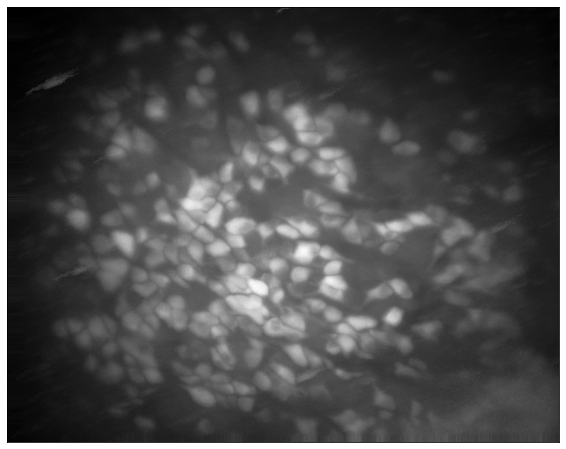

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(32, 8))
ax.imshow(max_proj, extent=[0, 1320, 0, 1040], cmap=plt.cm.Greys_r)
ax.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)

# Figure 2b

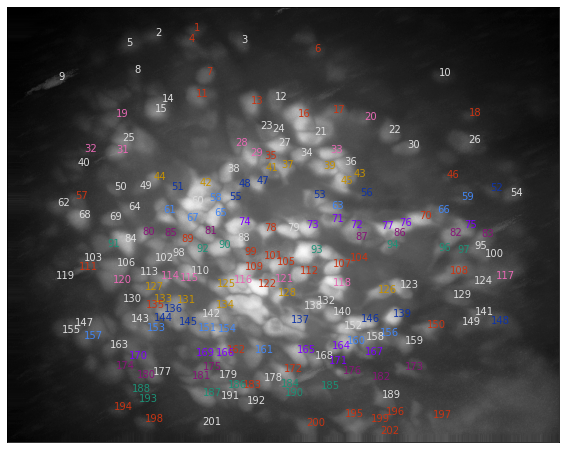

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(32, 8))
ax.imshow(max_proj, extent=[0, 1320, 0, 1040], cmap=plt.cm.Greys_r)

colors = np.array([[201/255, 52/255, 19/255],
                   [0.91, 0.41, 0.71],
                   [196/255, 145/255, 2/255],
                   [16/255, 52/255, 166/255],
                   [66/255, 134/255, 244/255],
                   [127/255, 0/255, 255/255],
                   [135/255, 21/255, 120/255],
                   [28/255, 145/255, 118/255]])


d1, d2 = np.shape(max_proj)
cm = com(cnm_seeded.estimates.A[:, cnm_seeded.estimates.idx_components], d1, d2)

ct = 0
color_cycle_ct = 0
for ii in range(cm.shape[0]):
    if ii in transients_detected_inds:
        div, mod = divmod(ct, 8)
        if mod == 0 and ct != 0:
            color_ct = (color_cycle_ct + 1) % 8
            color = colors[color_cycle_ct]
        else:
            color = colors[div % 8]
        ct += 1
    else:
        color = '#dddddd'
    
    x = cm[ii, 1]
    y = 1040 - cm[ii, 0]
    if y > 1000: # move positioning down so labels always visible
        y = 1010
    # will need to post-process with Illustrator for label alignments
    ax.text(x, y, str(ii+1), color=color)
    
ax.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)

# Figure 2c

(-7.0, 140.0)

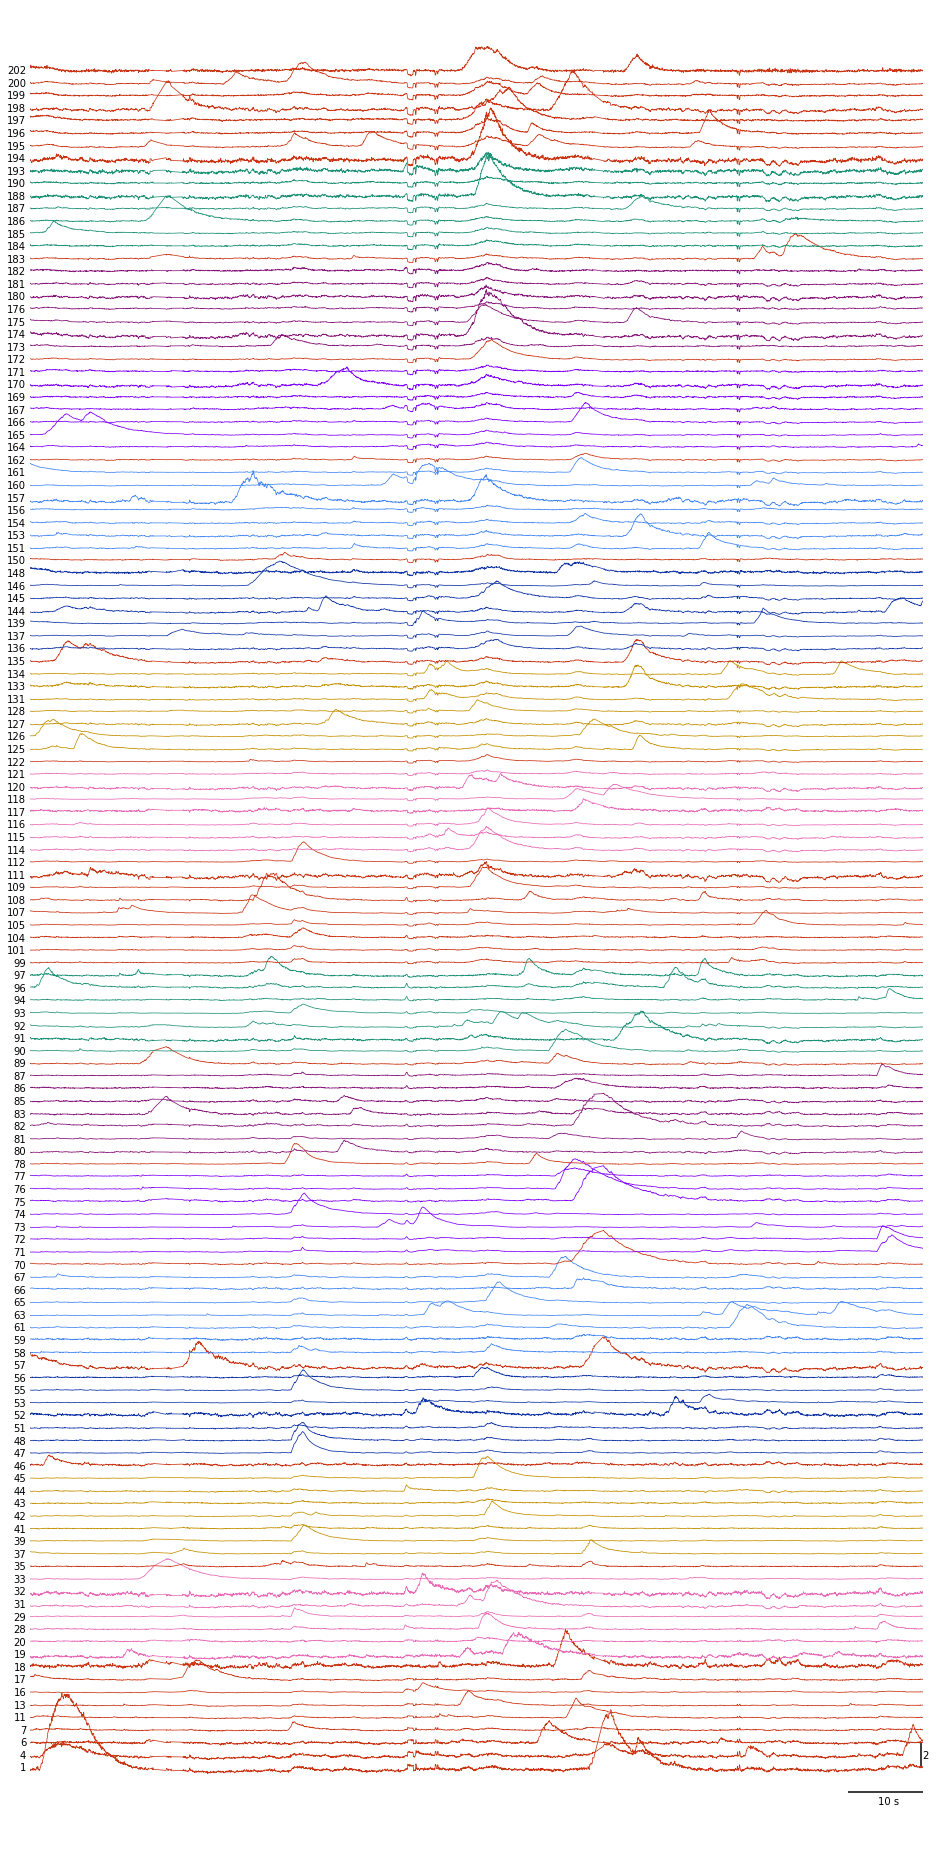

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(16, 34))

offsets = []
ct = 0
color_cycle_ct = 0
for ind in transients_detected_inds:
    offset = ct
    div, mod = divmod(ct, 8)
    if mod == 0 and ct != 0:
        color_ct = (color_cycle_ct + 1) % 8
        color = colors[color_cycle_ct]
    else:
        color = colors[div % 8]
    ax.plot(ca_activity.abscissa_vals, ca_activity.data[ind] + offset, color=color, lw=0.75)
    offsets.append(offset)
    ct += 1
    
ax.margins(x=0.1, tight=None)

ax.tick_params(axis='y', length=0, width=0)
ax.set_yticks(offsets)
ax.set_yticklabels(transients_detected_inds + 1)

ax.tick_params(axis='x', length=0, width=0)
ax.set_xticklabels([])

ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.hlines(-2, stop - 10, stop)
ax.annotate( '10 s', ( (stop - 6), -3), xycoords='data')

ax.vlines(start + 119.75, 0, 2)
ax.annotate('2', ((stop, 0.7)), xycoords='data')

ax.set_xlim(start, stop)
ax.set_ylim(offsets[0] - 7, offsets[-1] + 5)

# Figure 2d

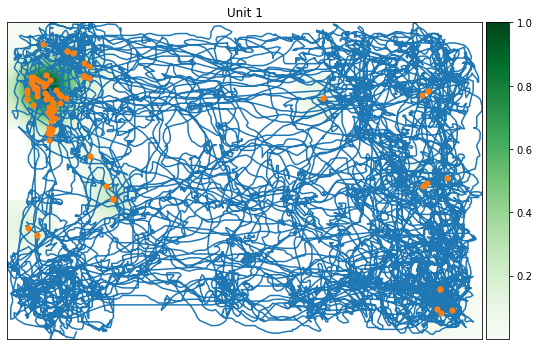

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(0.15*60, 0.15*40))

ax = display_ratemap(spikes_asa, pos2d_asa, run_epochs, norm_ratemap, 0, ax)

# Figure 2e

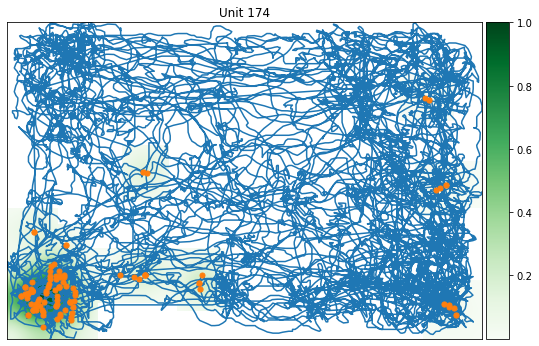

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(0.15*60, 0.15*40))

ax = display_ratemap(spikes_asa, pos2d_asa, run_epochs, norm_ratemap, 173, ax)

# Figure S6

(0.0, 1.0, 0.0, 1.0)

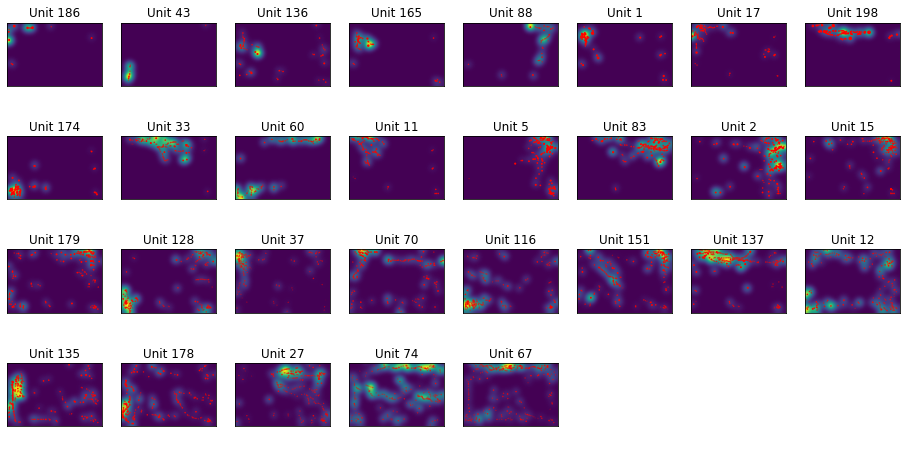

In [34]:
spike_data = spikes_asa[run_epochs].data
x_locs = pos2d_asa[run_epochs].data[0]
y_locs = pos2d_asa[run_epochs].data[1]

fig, ax = plt.subplots(4, 8, figsize=(16, 8))

for ind, unit in enumerate(place_cell_inds):
    
    smoothed_ratemap = sp.ndimage.gaussian_filter(norm_ratemap[unit], 2, truncate=3)
    smoothed_ratemap -= smoothed_ratemap.min()
    smoothed_ratemap /= smoothed_ratemap.max()
    
    ii, jj = np.unravel_index(ind, (4, 8))

    ax[ii, jj].imshow(smoothed_ratemap, extent=[0, 60, 0, 40], interpolation='bicubic')

    spikes = spike_data[unit]
    spikes *= 500
    mask = spikes > 0

    ax[ii, jj].scatter(x_locs[mask], 40 - y_locs[mask], s=spikes[mask], c='r')
    
    ax[ii, jj].set_title(f"Unit {unit + 1}")
    ax[ii, jj].tick_params(axis='both', which='both', bottom=False, labelbottom=False, left=False, labelleft=False)
    
ax[-1, -1].axis('off')
ax[-1, -2].axis('off')
ax[-1, -3].axis('off')